<a href="https://colab.research.google.com/github/Decoding-Data-Science/airesidency/blob/main/multi_agent_collaboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-agent network

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) architecture.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

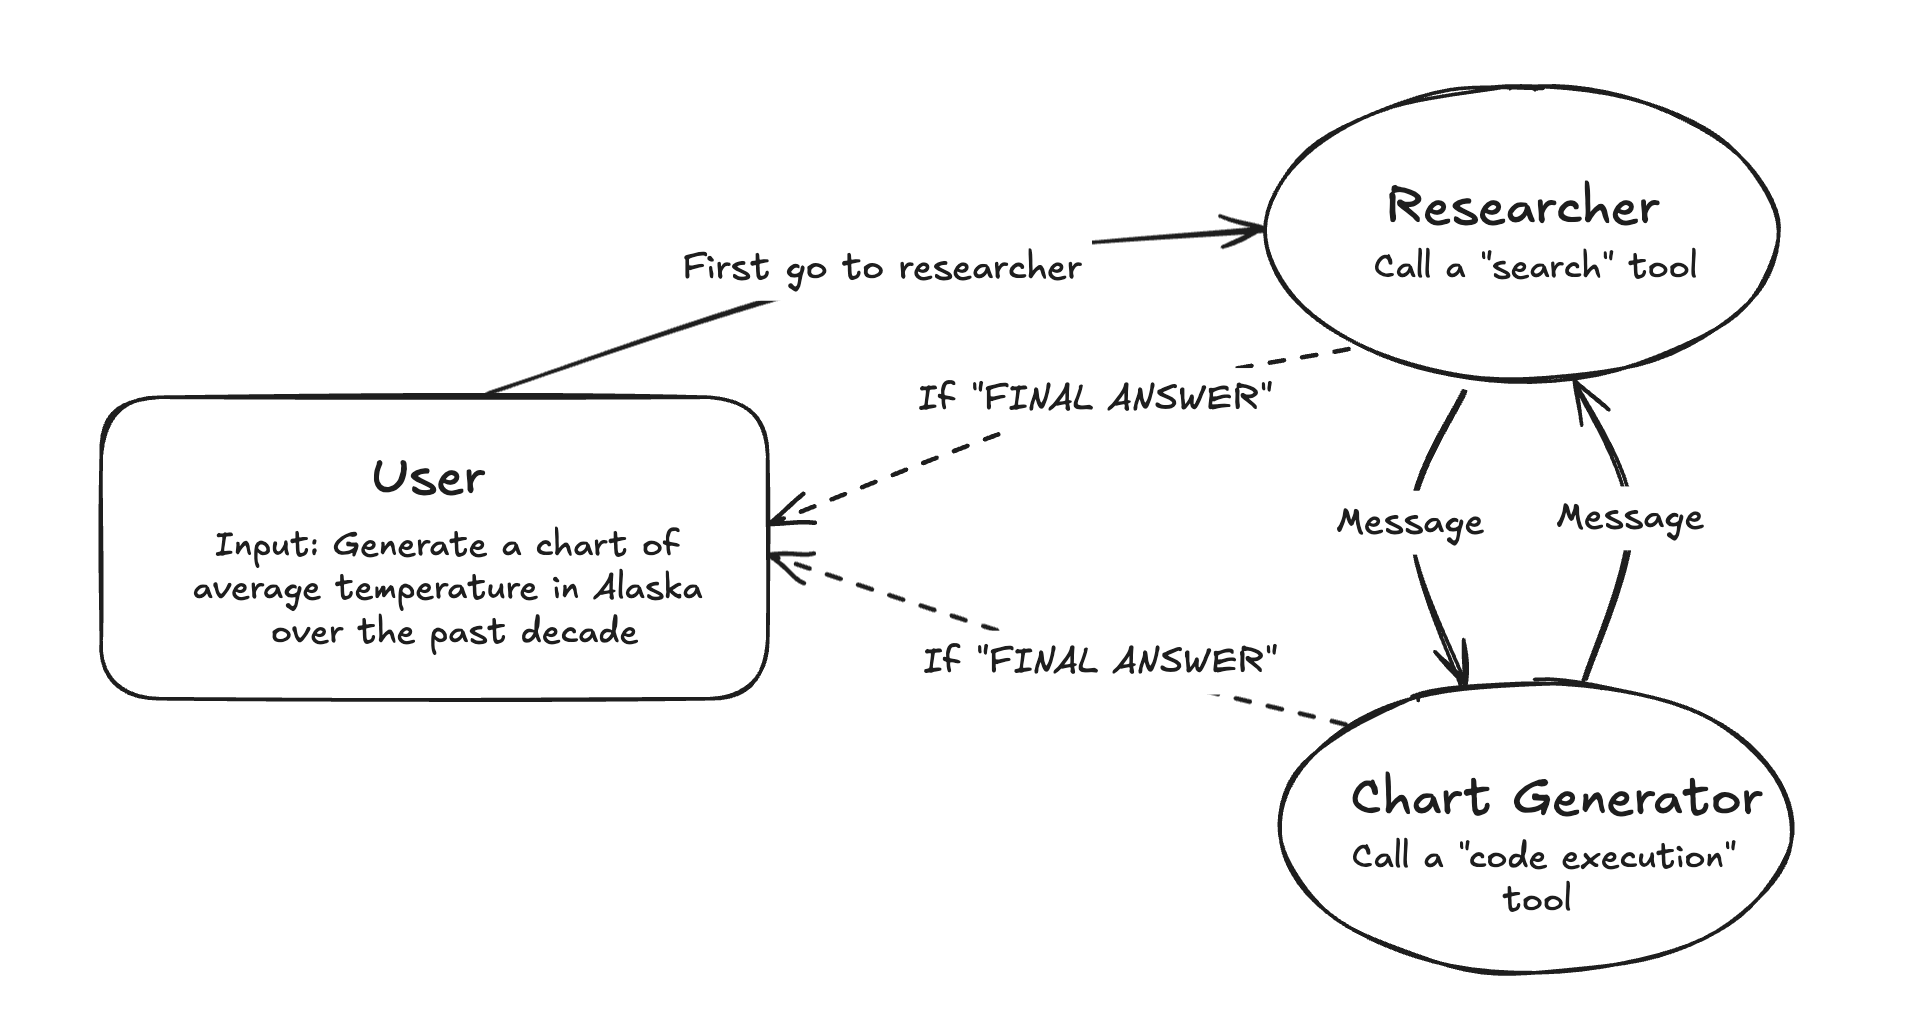

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install our required packages and set our API keys:

In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your ANTHROPIC_API_KEY··········
Please provide your TAVILY_API_KEY··········


Pre requisites

Anthropic Key
https://www.youtube.com/watch?v=N-QiJArCjx4&t=4s

Tavily AI Key
https://www.youtube.com/watch?v=CWt00q3ai4c&t=3s

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>

## Define tools

We will also define some tools that our agents will use in the future

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [4]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [12]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_anthropic import ChatAnthropic
#langgrapj
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Define the Graph

We can now put it all together and define the graph!

In [13]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

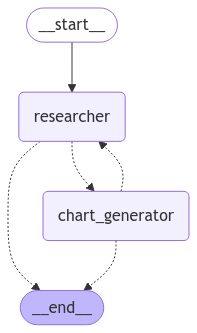

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

Verbose Mode: Displaying step-by-step outputs from LangGraph stream...
Step 1:
{'researcher': {'messages': [HumanMessage(content="First, get the USA's GDP over the past 5 years, then make a line chart of it. Add Data labels for each point. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='16e4105b-ba72-44bf-bb57-bcbf6e252ec9'), AIMessage(content=[{'text': "I'll help research the GDP data for the USA over the past 5 years. Let me search for this information.", 'type': 'text'}, {'id': 'toolu_01U2qJfwmqNoCoGkehHSFkHq', 'input': {'query': 'US GDP annual values last 5 years 2019-2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01EacQLN6uu7QphPqSwnMuEN', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 562, 'output_tokens': 98}}, id='run-da60c46d-2d0f-4e59-9e24-

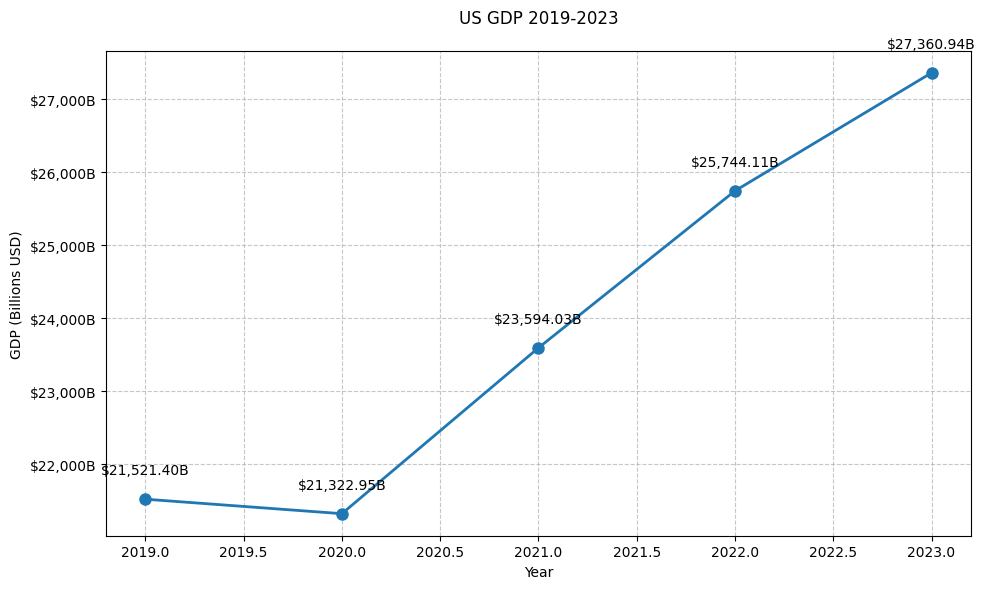

Step 2:
{'chart_generator': {'messages': [HumanMessage(content="First, get the USA's GDP over the past 5 years, then make a line chart of it. Add Data labels for each point. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='16e4105b-ba72-44bf-bb57-bcbf6e252ec9'), AIMessage(content=[{'text': "I'll help research the GDP data for the USA over the past 5 years. Let me search for this information.", 'type': 'text'}, {'id': 'toolu_01U2qJfwmqNoCoGkehHSFkHq', 'input': {'query': 'US GDP annual values last 5 years 2019-2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01EacQLN6uu7QphPqSwnMuEN', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 562, 'output_tokens': 98}}, id='run-da60c46d-2d0f-4e59-9e24-b821a88d1550-0', tool_calls=[{'name': 'tavily_search_results_json'

In [16]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the USA's GDP over the past 5 years, then make a line chart of it. Add Data labels for each point. "
                "Once you make the chart, finish.",
            )
        ],
    },
    {"recursion_limit": 150},  # Maximum number of steps to take in the graph
)

# Verbose: Print each step
print("Verbose Mode: Displaying step-by-step outputs from LangGraph stream...")
for idx, s in enumerate(events):
    print(f"Step {idx + 1}:")
    print(s)
    print("----")


{'researcher': {'messages': [HumanMessage(content="First, get the USA's GDP over the past 5 years, then make a line chart of it. Add Data labels for each point Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='05c68278-f736-46d6-a0ae-ed2daa0d9974'), AIMessage(content=[{'text': "I'll help search for the GDP data. Then my chart generator colleague will need to create the visualization.\n\nLet me search for recent US GDP data:", 'type': 'text'}, {'id': 'toolu_01VyKmmpfDoRWynD5wms5aY2', 'input': {'query': 'United States GDP annual values last 5 years 2019-2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01R1SoDkXG6p3dSy8CzWC3gz', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 561, 'output_tokens': 105}}, id='run-571fad0f-1716-41fc-9dcb-14c79a104594-0', tool_

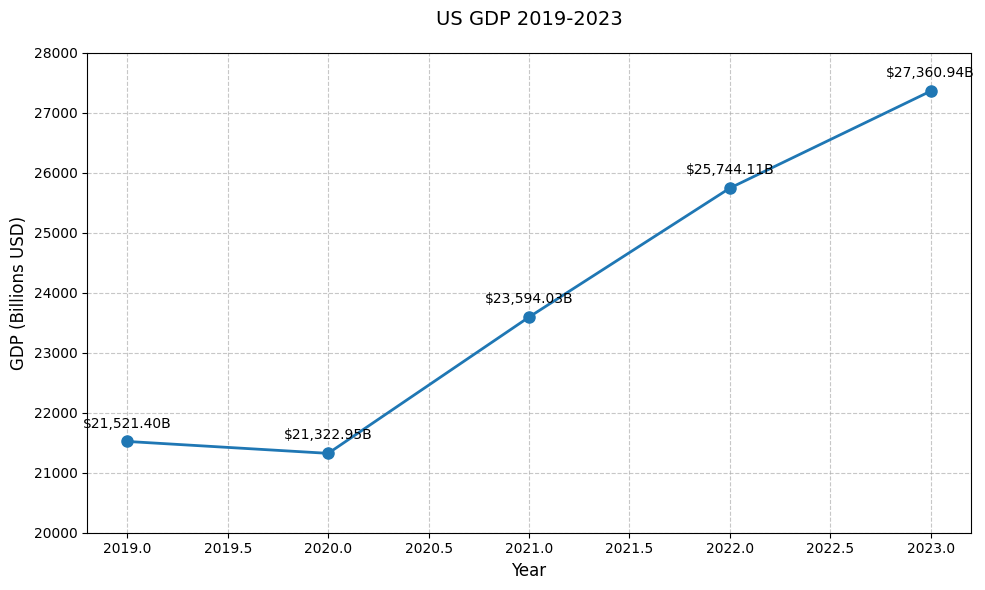

{'chart_generator': {'messages': [HumanMessage(content="First, get the USA's GDP over the past 5 years, then make a line chart of it. Add Data labels for each point Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='05c68278-f736-46d6-a0ae-ed2daa0d9974'), AIMessage(content=[{'text': "I'll help search for the GDP data. Then my chart generator colleague will need to create the visualization.\n\nLet me search for recent US GDP data:", 'type': 'text'}, {'id': 'toolu_01VyKmmpfDoRWynD5wms5aY2', 'input': {'query': 'United States GDP annual values last 5 years 2019-2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01R1SoDkXG6p3dSy8CzWC3gz', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 561, 'output_tokens': 105}}, id='run-571fad0f-1716-41fc-9dcb-14c79a104594-0', 

In [15]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the USA's GDP over the past 5 years, then make a line chart of it. Add Data labels for each point "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

In [ ]:
pip install gradio

In [11]:
import gradio as gr
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_anthropic import ChatAnthropic

# Define your LangGraph agents and nodes
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

# Research agent and node
def research_node(state: MessagesState) -> Command[str]:
    agent = create_react_agent(
        llm,
        tools=[],  # Define your tools if needed
        state_modifier=make_system_prompt("You can only do research.")
    )
    result = agent.invoke(state)
    goto = END if "FINAL ANSWER" in result["messages"][-1].content else "chart_generator"
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)

# Chart generator agent and node
def chart_node(state: MessagesState) -> Command[str]:
    agent = create_react_agent(
        llm,
        tools=[],  # Define your tools if needed
        state_modifier=make_system_prompt("You can only generate charts.")
    )
    result = agent.invoke(state)
    goto = END if "FINAL ANSWER" in result["messages"][-1].content else "researcher"
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)

# Initialize the LangGraph workflow
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "chart_generator")
workflow.add_edge("chart_generator", END)
graph = workflow.compile()

# Define the function to run the graph
def run_langgraph(user_input):
    # Start with user input
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"recursion_limit": 150}
    )
    # Collect outputs from the workflow
    output = []
    for event in events:
        output.append(event)
    # Return the final output
    return output[-1]["messages"][-1].content if output else "No output generated"

# Create Gradio interface
def process_input(user_input):
    result = run_langgraph(user_input)
    return result

interface = gr.Interface(
    fn=process_input,
    inputs="text",
    outputs="text",
    title="LangGraph Research Automation",
    description="Enter your research task (e.g., 'Get GDP data for the USA over the past 5 years and create a chart.')."
)

# Launch the Gradio interface
if __name__ == "__main__":
    interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9d72789b3838b18b1e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
